
# MSM of Brownian dynamics simulations of diffusion on a 2D surface
Here we analyze simulations on another simple mode system, but one that goes beyond one dimension. As always we start by importing some relevant libraries.

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import time
import itertools
import h5py
import numpy as np
from scipy.stats import norm
from scipy.stats import expon

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

Here we upload the data obtained from Brownian Dynamics simulations of isotropic diffusion on a 2D potential.

In [5]:
h5file = "data/cossio_kl1.3_Dx1_Dq1.h5"
f = h5py.File(h5file, 'r')
data = np.array(f['data'])
f.close()

### Trajectory analysis

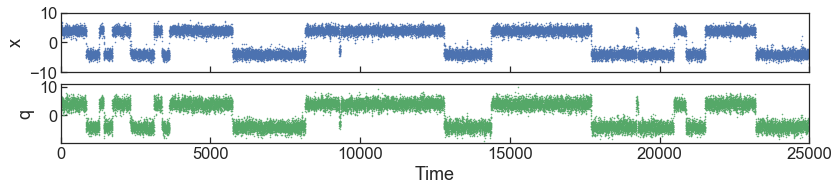

In [7]:
fig, ax = plt.subplots(2,1,figsize=(12,3), sharex=True,sharey=False)
ax[0].plot(data[:,0],data[:,1],'.', markersize=1)
ax[1].plot(data[:,0],data[:,2],'g.', markersize=1)
ax[0].set_ylim(-10,10)
ax[1].set_xlim(0,25000)
ax[0].set_ylabel('x')
ax[1].set_ylabel('q')
ax[1].set_xlabel('Time')
plt.tight_layout(h_pad=0)

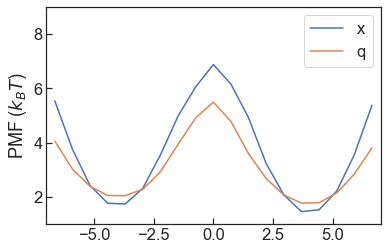

In [14]:
fig, ax = plt.subplots(figsize=(6,4))
hist, bin_edges = np.histogram(data[:,1], bins=np.linspace(-7,7,20), \
                               density=True)
bin_centers = [0.5*(bin_edges[i]+bin_edges[i+1]) \
               for i in range(len(bin_edges)-1)]
ax.plot(bin_centers, -np.log(hist),label="x")
hist, bin_edges = np.histogram(data[:,2], bins=np.linspace(-7,7,20), \
                               density=True)
bin_centers = [0.5*(bin_edges[i]+bin_edges[i+1]) \
               for i in range(len(bin_edges)-1)]
ax.plot(bin_centers, -np.log(hist),label="q")
ax.set_xlim(-7,7)
ax.set_ylim(1,9)
#ax.set_xlabel('x')
ax.set_ylabel('PMF ($k_BT$)')
ax.legend()


Representation of the bistable 2D free energy surface as a function of the measured q and molecular x extensions:

/home/daviddesancho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


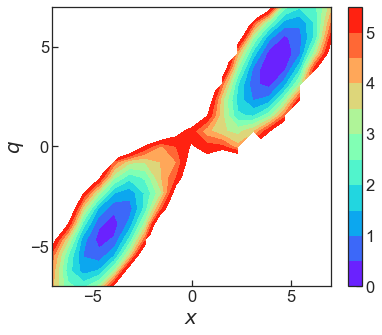

In [16]:
H, x_edges, y_edges = np.histogram2d(data[:,1],data[:,2], \
            bins=[np.linspace(-7,7,20), np.linspace(-7,7,20)])

fig, ax = plt.subplots(figsize=(6,5))
pmf = -np.log(H.transpose())
pmf -= np.min(pmf)
cs = ax.contourf(pmf, extent=[x_edges.min(), x_edges.max(), \
                     y_edges.min(), y_edges.max()], \
                   cmap=cm.rainbow, levels=np.arange(0, 6,0.5))

cbar = plt.colorbar(cs)
ax.set_xlim(-7,7)
ax.set_ylim(-7,7)
ax.set_yticks(range(-5,6,5))
ax.set_xlabel('$x$', fontsize=20)
ax.set_ylabel('$q$', fontsize=20)
plt.tight_layout()

### Assignment

Now we discretize the trajectory using the states obtained from partitioning the 2D free energy surface of the diffusion of the molecule. We first need to import the function that makes the grid.


In [17]:
from scipy.stats import binned_statistic_2d

In [18]:
statistic, x_edge, y_edge, binnumber = \
    binned_statistic_2d(data[:,1],data[:,2],None,'count', \
                        bins=[np.linspace(-7,7,20), np.linspace(-7,7,20)])

/home/daviddesancho/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


/home/daviddesancho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


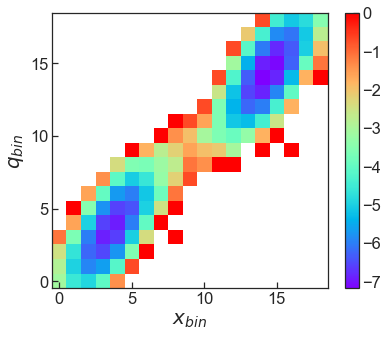

In [19]:
fig, ax = plt.subplots(figsize=(6,5))

grid = ax.imshow(-np.log(statistic.transpose()),origin="lower",cmap=plt.cm.rainbow)

cbar = plt.colorbar(grid)
ax.set_yticks(range(0,20,5))
ax.set_xticks(range(0,20,5))
ax.set_xlabel('$x_{bin}$', fontsize=20)
ax.set_ylabel('$q_{bin}$', fontsize=20)
plt.tight_layout()

(0, 2000)

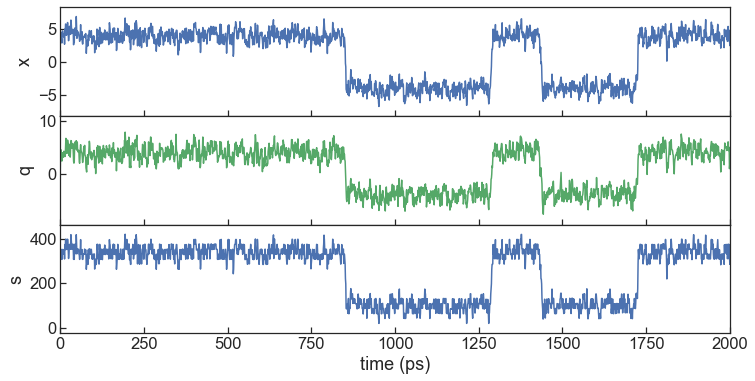

In [21]:
fig,ax=plt.subplots(3,1,figsize=(12,6),sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)
ax[0].plot(range(0,len(data[:,1])),data[:,1])
ax[1].plot(range(0,len(data[:,2])),data[:,2],color="g")
ax[2].plot(binnumber)
ax[0].set_ylabel('x')
ax[1].set_ylabel('q')
ax[2].set_ylabel("s")
ax[2].set_xlabel("time (ps)")
ax[2].set_xlim(0,2000)

### Master Equation Model 

In [22]:
from mastermsm.trajectory import traj
from mastermsm.msm import msm

In [23]:
distraj = traj.TimeSeries(distraj=list(binnumber), dt=1)
distraj.find_keys()
distraj.keys.sort()

In [24]:
msm_2D = msm.SuperMSM([distraj])

     # states: 150


#### Convergence Test

In [25]:
for i in [1, 2, 5, 10, 20, 50, 100]:
    msm_2D.do_msm(i)
    msm_2D.msms[i].do_trans(evecs=True)
    msm_2D.msms[i].boots()

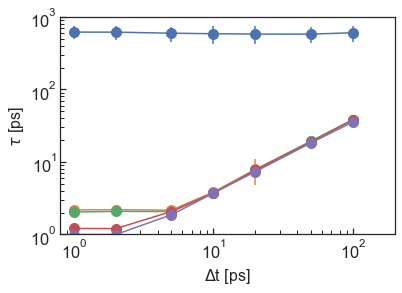

In [26]:
fig, ax = plt.subplots()
for i in range(5):
    tau_vs_lagt = np.array([[x,msm_2D.msms[x].tauT[i],msm_2D.msms[x].tau_std[i]] \
               for x in sorted(msm_2D.msms.keys())])
    ax.errorbar(tau_vs_lagt[:,0],tau_vs_lagt[:,1],fmt='o-', yerr=tau_vs_lagt[:,2], markersize=10)
#ax.fill_between(10**np.arange(-0.2,3,0.2), 1e-1, 10**np.arange(-0.2,3,0.2), facecolor='lightgray')
ax.set_xlabel(r'$\Delta$t [ps]', fontsize=16)
ax.set_ylabel(r'$\tau$ [ps]', fontsize=16)
ax.set_xlim(0.8,200)
ax.set_ylim(1,1000)
ax.set_yscale('log')
_ = ax.set_xscale('log')

There is no dependency of the relaxation times $\tau$ on the lag time $\Delta$t.


#### Estimation

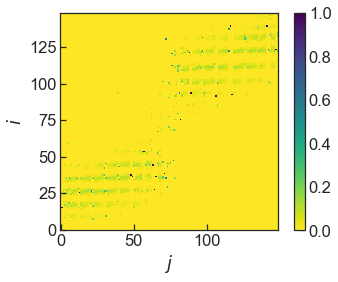

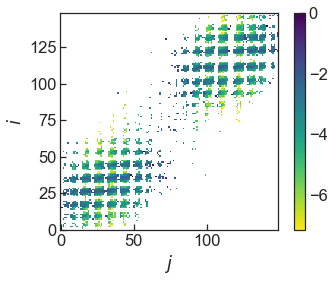

In [27]:
lt=2
plt.figure()
plt.imshow(msm_2D.msms[lt].trans, interpolation='none', \
    cmap='viridis_r',origin="lower")
plt.ylabel('$\it{i}$')
plt.xlabel('$\it{j}$')
plt.colorbar()
plt.figure()
plt.imshow(np.log(msm_2D.msms[lt].trans), interpolation='none', \
    cmap='viridis_r',origin="lower")
plt.ylabel('$\it{i}$')
plt.xlabel('$\it{j}$')
plt.colorbar()

Text(0, 0.5, '$\\tau_i$ [ns]')

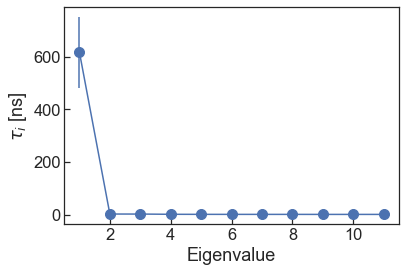

In [28]:
fig, ax = plt.subplots()
ax.errorbar(range(1,12),msm_2D.msms[lt].tauT[0:11], fmt='o-', \
            yerr= msm_2D.msms[lt].tau_std[0:11], ms=10)
ax.set_xlabel('Eigenvalue')
ax.set_ylabel(r'$\tau_i$ [ns]') 

The first mode captured by $\lambda_1$ is significantly slower than the others. That mode, which is described by the right eigenvector $\psi^R_1$ as the transition of the protein between the folded and unfolded states.

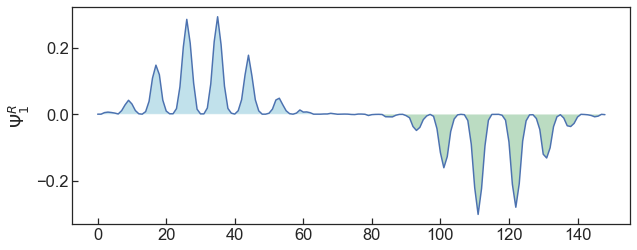

In [29]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(msm_2D.msms[2].rvecsT[:,1])
ax.fill_between(range(len(msm_2D.msms[lt].rvecsT[:,1])), 0, \
                msm_2D.msms[lt].rvecsT[:,1], \
                where=msm_2D.msms[lt].rvecsT[:,1]>0,\
                facecolor='c', interpolate=True,alpha=.4)
ax.fill_between(range(len(msm_2D.msms[lt].rvecsT[:,1])), 0, \
                msm_2D.msms[lt].rvecsT[:,1], \
                where=msm_2D.msms[lt].rvecsT[:,1]<0,\
                facecolor='g', interpolate=True,alpha=.4)
ax.set_ylabel("$\Psi^R_1$")
plt.show()

The projection of $\psi^R_1$ on the 2D grid shows the transitions between the two conformational states (red and blue).

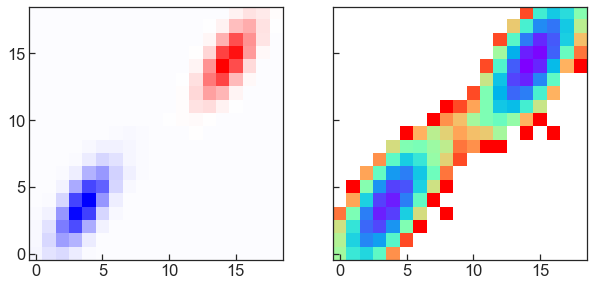

In [32]:
fig,ax = plt.subplots(1,2,figsize=(10,5),sharey=True,sharex=True)
rv_mat = np.zeros((20,20), float)
for i in [x for x in zip(msm_2D.msms[lt].keep_keys, \
                         msm_2D.msms[lt].rvecsT[:,1])]:
    unr_ind=np.unravel_index(i[0],(21,21))    
    rv_mat[unr_ind[0]-1,unr_ind[1]-1] = -i[1]
ax[0].imshow(rv_mat.transpose(), interpolation="none", \
             cmap='bwr',origin="lower")
ax[1].imshow(-np.log(statistic.transpose()), \
             cmap=plt.cm.rainbow,origin="lower")
ax[1].set_yticks(range(0,20,5))
ax[1].set_xticks(range(0,20,5))